<img style="float:right" src="images/logo_va.png" /> 

# Visione Artificiale
## Esercitazione: Calibrazione di una telecamera

### Sommario
* Verifica empirica della presenza di distorsioni geometriche in un'immagine
* Ricerca di un pattern di calibrazione a forma di scacchiera all'interno delle immagini
* Stima dei parametri intrinseci ed estrinseci della telecamera a partire da una serie di immagini del pattern di calibrazione
* Correzione della distorsione geometrica di un'immagine
* Utilizzo dei parametri ottenuti per disegnare punti 3D all'interno di un'immagine

Iniziamo con l'importazione dei moduli che ci serviranno: `NumPy`, `OpenCV`, `va`. Importiamo anche la funzione `interact` di Jupyter. 

In [3]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

<img style="float:left" src="images/ar.png" /> **Esercizio 1** - Leggere da file l'immagine `test.jpg` dalla cartella `calibrazione`, definire una variabile `test_image` con il contenuto dell'immagine.
Creare una copia dell'immagine chiamata `test_image_with_lines` disegnandovi sopra quattro linee rosse che colleghino i punti nella lista `punti_test`.  
Suggerimento: è possibile utilizzare `cv.line` più volte, oppure una sola chiamata di `cv.polylines` (attenzione al parametro `pts` che richiede un elenco di poligoni, anche se nel nostro caso vi è un solo poligono. A tale parametro può essere passato ad esempio un array NumPy con shape (1, 4, 2), la prima dimensione indica i poligoni, la seconda il numero di punti di ciascun poligono e la terza il numero di coordinate di ciascun punto).

Se l'immagine nella variabile `test_image_with_lines` è corretta, le due immagini di output  devono essere identiche.
**Si osservi come sia presente distorsione geometrica nell'immagine: le linee che dovrebbero essere diritte sono curve (l'effetto è più visibile man mano che ci si allontana dal centro dell'immagine).**

Risultato ottenuto,Risultato atteso
,

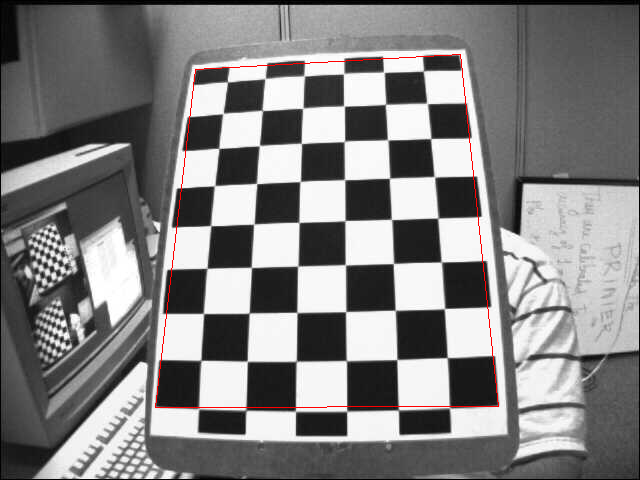
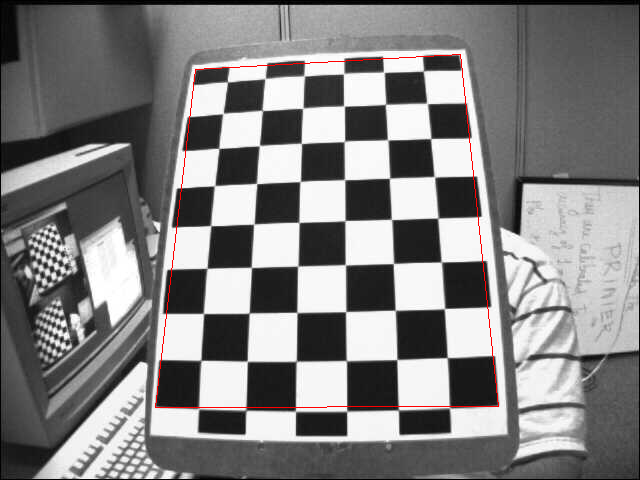

In [22]:
punti_test = [(195,69), (155,407), (498,406), (460,54)]

# --- Svolgimento Esercizio 1: Inizio --- #

test_image = cv.imread('calibrazione/test.jpg')
test_image_with_lines = test_image.copy()

#test_image_with_lines= cv.polylines(test_image_with_lines, [punti_test], 
 #                     isClosed, color, thickness)

cv.line(test_image_with_lines,(498,406),(460,54),(0,0,255),1)
cv.line(test_image_with_lines,(498,406),(155,407),(0,0,255),1)
cv.line(test_image_with_lines,(195,69),(460,54),(0,0,255),1)
cv.line(test_image_with_lines,(195,69),(155,407),(0,0,255),1)


# --- Svolgimento Esercizio 1: Fine --- #

va.show((test_image_with_lines,'Risultato ottenuto'), (cv.imread('calibrazione/es1.png'),'Risultato atteso'))

<img style="float:left" src="images/ar.png" /> **Esercizio 2** - Completare la funzione `trova_scacchiera` nella cella seguente. La funzione deve convertire l'immagine nel parametro `img` in grayscale e quindi chiamare `cv.findChessboardCorners` che restituisce una tupla `(ret, corners)`; `ret` è `True` se la ricerca ha avuto successo: in tal caso richiamare la funzione `cv.cornerSubPix` per migliorare la precisione con accuratezza sub-pixel, utilizzando `(11,11)`, `(-1,-1)` e `CRITERI_TERMINAZIONE` come valori dei parametri `winSize`, `zeroZone` e `criteria`, rispettivamente. La funzione `trova_scacchiera` deve restituire a sua volta la tupla `(ret, corners)`, dove `corners` contiene quanto restituito da `cv.cornerSubPix` (se è stata chiamata), oppure quanto restituito da `cv.findChessboardCorners` se `ret` è `False`.

In [5]:
VERTICI_SCACCHIERA = (7,6) # Numero dei vertici della scacchiera da trovare

def trova_scacchiera(img):
    CRITERI_TERMINAZIONE = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)    
    
    # --- Svolgimento Esercizio 2: Inizio --- #
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    ret, corners = cv.findChessboardCorners(img_gray, VERTICI_SCACCHIERA)
    
    if ret:
        corners = cv.cornerSubPix(img_gray, corners, (11,11), (-1,-1), CRITERI_TERMINAZIONE)
        
    return (ret, corners)
    # --- Svolgimento Esercizio 2: Fine --- #

Se la funzione è stata implementata correttamente, le due immagini output della cella seguente devono essere identiche.

Risultato ottenuto (ret=True),Risultato atteso
,

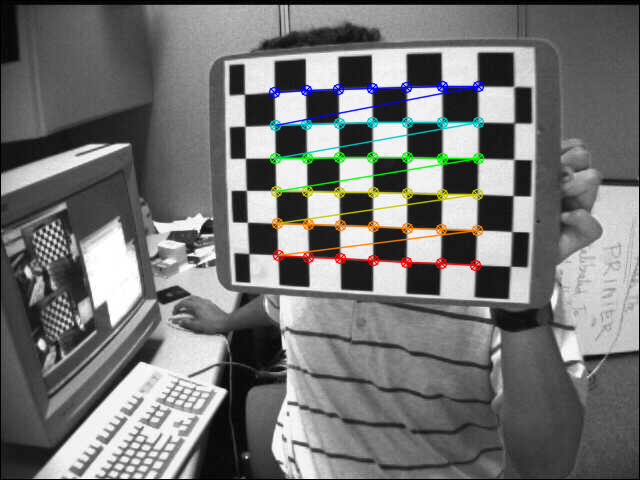
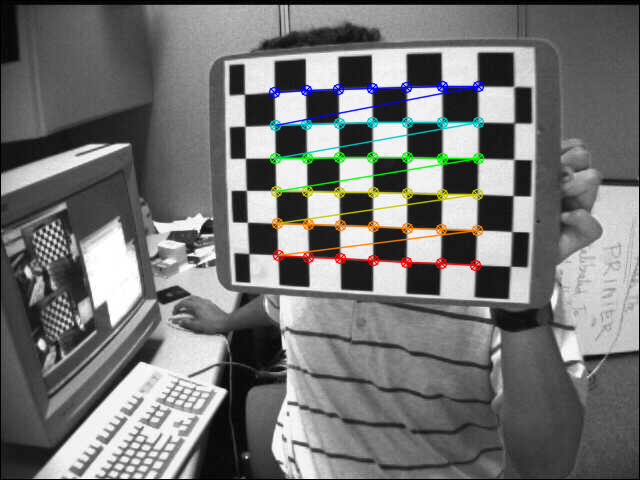

In [44]:
img = cv.imread('calibrazione/sample_1.jpg')
h, w = img.shape[:2] # salva le dimensioni dell'immagine: saranno utili in seguito
ret, corners = trova_scacchiera(img)
cv.drawChessboardCorners(img, VERTICI_SCACCHIERA, corners, ret)
va.show((img, f"Risultato ottenuto (ret={ret})"),(cv.imread('calibrazione/es2.png'),'Risultato atteso'))

A questo punto eseguiamo la stessa procedura per una serie di immagini e creiamo due liste: `punti_immagine` e `punti_oggetto`. La prima conterrà, per ciascuna immagine, le 42 coordinate 2D dei punti restituite da `trova_scacchiera`, la seconda conterrà le corrispondenti coordinate nello spazio 3D. A tal fine, è necessario scegliere un sistema di coordinate nello spazio 3D: per semplicità scegliamo quello nell'immagine seguente, con i lati della scacchiera che corrispondono agli assi X e Y e quindi l'asse Z perpendicolare al piano su cui poggia la scacchiera stessa.
![Sistema di coordinate 3D](calibrazione/coord_3d.jpg)
Come unità di misura nello spazio 3D scegliamo il lato delle case della scacchiera: in questo modo le coordinate dei punti `(X,Y,Z)` nello spazio saranno: `(0,0,0), (1,0,0), (2,0,0), ..., (6,0,0), (0,1,0), (1,1,0), ..., (6,1,0), ..., (6,5,0)` (tutti i punti sulla scacchiera hanno coordinata `Z = 0`).


<img style="float:left" src="images/ar.png" /> **Esercizio 3** - Inizializzare le variabili `immagini`, `punti_immagine` e `punti_oggetto` con tre liste vuote. Predisporre una variabile `po` contenente un array NumPy con shape `(42,3)` con elementi di tipo `np.float32`, contenente le coordinate `(X,Y,Z)` dei 42 vertici nell'ordine esemplificato nella cella precedente. La cella successiva esegue alcuni controlli per verificare che le variabili siano state definite correttamente. Suggerimento: ci sono ovviamente molti modi diversi per inizializzare `po`, il modo più semplice è probabilmente utilizzare due cicli `for`, altri metodi prevedono l'utilizzo di metodi quali `np.mgrid`, `np.arange`, `np.tile`, `np.repeat`.

In [7]:
immagini, punti_immagine, punti_oggetto, po = [None] * 4

# --- Svolgimento Esercizio 3: Inizio --- #

immagini, punti_immagine, punti_oggetto= [],[],[]

po = np.array( [ [x,y,0] for y in range(6) for x in range(7) ], dtype=np.float32)#.shape


# --- Svolgimento Esercizio 3: Fine --- #

In [62]:
va.test_calibrazione_3(immagini, punti_immagine, punti_oggetto, po)

immagini,punti_immagine,punti_oggetto,po
,,,


<img style="float:left" src="images/ar.png" /> **Esercizio 4** - Per ciascuna delle immagini `calibrazione/sample_n.jpg` (con n=1..12), eseguire `trova_scacchiera` e, se ha successo, aggiungere i punti trovati alla lista `punti_immagine` e, contestualmente, aggiungere l'array `po` a `punti_oggetto` (infatti le coordinate dei 42 punti nello spazio 3D sono sempre le stesse e sono già contenute in `po`) e aggiungere l'immagine alla lista `immagini`. Al termine dell'esecuzione la lunghezza delle tre liste deve essere ovviamente la stessa.

In [8]:
# --- Svolgimento Esercizio 4: Inizio --- #

for i in range(12):
    img = cv.imread(f"calibrazione/sample_{i+1}.jpg")
    ret, corners = trova_scacchiera(img)
    if ret:
        punti_immagine.append(corners)
        punti_oggetto.append(po)
        immagini.append(img)
        
# --- Svolgimento Esercizio 4: Fine --- #

<img style="float:left" src="images/in.png" /> Se l'esercizio precedente è stato svolto correttamente, l'esecuzione della cella seguente consente di visualizzare in modo interattivo le immagini su cui la ricerca della scacchiera ha avuto successo, visualizzando i 42 punti ciascuno con le sue corrispondenti coordinate 3D.

In [9]:
@interact(indice=(0,len(immagini)-1))
def f(indice=0):
    tmp = immagini[indice].copy()
    for i in range(42):
        u, v = tuple(punti_immagine[indice][i,0].round().astype(int))
        cv.circle(tmp, (u,v), 3, (0,0,255), cv.FILLED)
        x, y, z = punti_oggetto[indice][i].astype(int)
        cv.putText(tmp, f'({x},{y},{z})', (u-4, v+10), cv.FONT_HERSHEY_COMPLEX, 0.3, (0,0,255))
    va.show(tmp,f'Immagine {indice}')    

interactive(children=(IntSlider(value=0, description='indice', max=9), Output()), _dom_classes=('widget-intera…

Ora che abbiamo definito per una serie di immagini la corrispondenza fra le coordinate nella scena 3D e le corrispondenti coordinate 2D, **siamo pronti per la calibrazione**. Eseguendo la cella seguente, la funzione `cv.calibrateCamera` calcolerà:
* l'errore medio di riproiezione: `err`;
* parametri intrinseci $
\left( \begin{array}{ccc}
\frac{f}{s_x} & 0 & c_x \\
0 & \frac{f}{s_y} & c_y \\
0 & 0 & 1 \end{array} \right)
$ : `matIntr`, dove $f$ è la lunghezza focale, $(s_x,s_y)$ le dimensioni dei pixel e $(c_x,c_y)$ il punto principale;
* i coefficienti di distorsione $(k_1, k_2, p_1, p_2, k_3)$: `distCoeff`, in particolare si noti che $k_1<0$ indica una *barrel distortion*; 
* i parametri estrinseci `rotEstr` e `traEstr`: si tratta di due liste che contengono rispettivamente, per ciascuna immagine, un vettore con i 3 parametri di rotazione e uno con i 3 di traslazione.

In [69]:
err, matIntr, distCoeff, rotEstr, traEstr = cv.calibrateCamera(punti_oggetto, punti_immagine, (w,h), None, None)

with np.printoptions(formatter={'float': lambda f: f'{f:9.4f}'}):
    print(f'Errore medio di riproiezione = {err:.4f}')
    print('Parametri intrinseci della telecamera:')
    print(matIntr)
    print('Coefficienti di distorsione: ', distCoeff.ravel())
    print('Parametri di rotazione e traslazione per ciascuna immagine:')
    print(*[f'{i}: {r.ravel()} {t.ravel()}' for i,(r,t) in enumerate(zip(rotEstr,traEstr))], sep='\n')

Errore medio di riproiezione = 0.1532
Parametri intrinseci della telecamera:
[[ 533.9035    0.0000  340.9233]
 [   0.0000  534.0165  232.5545]
 [   0.0000    0.0000    1.0000]]
Coefficienti di distorsione:  [  -0.2957    0.1359    0.0014   -0.0001   -0.0199]
Parametri di rotazione e traslazione per ciascuna immagine:
0: [  -0.4335    0.2551   -3.0884] [   3.8149    0.9100   14.8507]
1: [   0.4142    0.6572   -1.3378] [  -2.1095    1.8547   12.8097]
2: [  -0.2661   -0.3944   -2.7475] [   3.0483    2.7538    9.8909]
3: [  -0.3798   -0.1817   -3.1160] [   2.8362    2.2319   10.9500]
4: [  -0.4614   -0.3141   -1.7608] [  -1.1289    2.6810    9.5585]
5: [  -0.3004    0.3921   -1.4349] [   1.6224    3.8247   16.1129]
6: [  -0.3215    0.1603   -1.2415] [  -5.9237    2.4088   16.7789]
7: [  -0.4601   -0.0881   -1.3348] [  -3.2656    2.1665   11.7264]
8: [   0.3056    0.5042   -1.8286] [  -1.2053    3.5325   15.6674]
9: [  -0.1724   -0.4662    1.3477] [   1.8337   -4.2550   12.4534]


<img style="float:left" src="images/in.png" /> La cella seguente mostra come rettificare la distorsione in un'immagine.  
Prima di procedere, è possibile modificare la matrice `matIntr` applicando un parametro di scala `alpha` con la funzione `getOptimalNewCameraMatrix`. Se `alpha=0`, l'immagine rettificata conterrà tutti pixel validi (ossia presenti nell'immagine di partenza), eventualmente rimuovendo zone di bordo (in pratica è come se la telecamera si avvicinasse all'oggetto), se invece `alpha=1`, tutti i pixel nell'immagine di partenza saranno considerati, eventualmente aggiungendo pixel neri ai bordi (in pratica è come se la telecamera si allontanasse dall'oggetto). La cella seguente consente di sperimentare cosa succede per valori di `alpha` compresi fra 0 e 1. La rettificazione vera e propria avviene grazie alla funzione `undistort`. Inoltre è possibile rettificare anche una serie di coordinate 2D di pixel nell'immagine originale mediante la funzione `undistortPoints`, che nella cella seguente viene utilizzata per disegnare lo stesso quadrilatero che era stato disegnato all'inizio di questa esercitazione per evidenziare la distorsione. Si può osservare come nell'immagine rettificata, le linee della scacchiera siano effettivamente diritte.

In [1]:
@interact(alpha=(0.0,1.0,0.1))
def correggi_distorsione(alpha=1):
    matIntr2, _ = cv.getOptimalNewCameraMatrix(matIntr,distCoeff,(w,h),alpha)
    img_ret = cv.undistort(test_image, matIntr, distCoeff, None, matIntr2)
    points = np.array([punti_test], np.float32)
    dPt = cv.undistortPoints(points, matIntr, distCoeff, None, matIntr2)
    dPt = dPt.round().astype(int)
    cv.polylines(img_ret,  [dPt], True, (0,0,255))
    va.show((img_ret,'Rettificata'), (test_image_with_lines,'Originale'))

NameError: name 'interact' is not defined

<img style="float:left" src="images/ar.png" /> **Esercizio 5** - Completare il codice nella cella seguente facendo in modo che la funzione `correggi_distorsione`: 1) calcoli la nuova matrice matIntr2 in base al parametro `alpha`; 2) carichi l'immagine `img` dal file `calibrazione/sample_{i+1}.jpg`; 3) ottenga l'immagine rettificata `img_ret`; 4) utilizzi `va.show` per mostrare entrambe le immagini.

Una volta che il codice funziona, controllare visivamente che la distorsione venga effettivamente corretta in tutte le 12 immagini.

In [75]:
@interact(alpha=(0.0,1.0,0.1), i=(0,11))
def correggi_distorsione(alpha=1, i=0):

    # --- Svolgimento Esercizio 5: Inizio --- #
    matIntr2, _ = cv.getOptimalNewCameraMatrix(matIntr,distCoeff,(w,h),alpha)
    
    img = cv.imread(f"calibrazione/sample_{i+1}.jpg")
    
    img_ret = cv.undistort(img, matIntr, distCoeff, newCameraMatrix= matIntr2)
    
    va.show(img, img_ret)
    # --- Svolgimento Esercizio 5: Fine --- #

interactive(children=(FloatSlider(value=1.0, description='alpha', max=1.0), IntSlider(value=0, description='i'…

Ora che sono noti i parametri intrinseci della telecamera e i parametri estrinseci per ciascuna delle immagini considerate, è possibile *proiettare punti dallo spazio tridimensionale alle immagini 2D*. Questo consente, ad esempio, di disegnare oggetti 3D sull'immagine in modo coerente.

<img style="float:left" src="images/ar.png" /> **Esercizio 6** - In quest'ultimo esercizio disegneremo un cubo sopra alla scacchiera. Nella cella seguente, implementate la funzione `vertici_cubo(x, y, z, s)` che restituisce un array NumPy di tipo `np.float32` con shape `(8, 3)` contenente le coordinate 3D degli 8 vertici di un cubo con spigoli di lunghezza $s$, posizionato con un vertice alle coordinate $(x,y,z)$ come in figura (attenzione a rispettare l'ordine dei vertici e al posizionamento del cubo rispetto all'asse $z$). Si noti che nella figura il vertice $p_0$ si trova per semplicità nell'origine degli assi: questo equivale a $x=0, y=0, z=0$: la funzione da realizzare non deve posizionare $p_0$ nell'origine, ma alle coordinate $(x,y,z)$ in base ai corrispondenti parametri che le sono passati.
![Vertici del cubo](calibrazione/cube.png)

A questo punto si esamini il codice nella cella seguente: la funzione `cubo_su_immagine` riceve l'indice dell'immagine (`i`), le coordinate `x` e `y` del cubo e la dimensione dello spigolo `s`. Come detto in precedenza, abbiamo scelto come sistema di riferimento la scacchiera, con l'asse $z$ perpendicolare ad essa (valori negativi di `z` corrispondono a spostarsi verso la telecamera); l'unità di misura è il lato delle case della scacchiera. La funzione `cv.projectPoints` esegue la proiezione di un elenco di punti dallo spazio 3D alle coordinate 2D dell'immagine a cui corrispondono i parametri estrinseci passati: restituisce l'elenco delle corrispondenti coordinate 2D. La funzione `disegna_cubo` utilizza tali coordinate 2D per disegnare sull'immagine i 12 vertici del cubo.

<img style="float:left" src="images/in.png" /> Utilizzare i vari slider per provare molteplici combinazioni di parametri: osservare come il cubo può essere "spostato" a piacere sopra alla scacchiera in ciascuna delle immagini.

In [ ]:
# --- Svolgimento Esercizio 6: Inizio --- #



# --- Svolgimento Esercizio 6: Fine --- #

In [76]:
def disegna_cubo(img, v):
    cv.polylines(img, [v[:4]], True, (0,255,0), 5)
    cv.polylines(img, np.array([v[i::4] for i in range(4)]), False, (0,0,255), 5)
    cv.polylines(img, [v[4:8]], True, (255,0,0), 5)

@interact(i=(0,9), x=(0,6), y=(0,5), s=(1,3))
def cubo_su_immagine(i=0, x=0, y=0, s=1):
    vp, _ = cv.projectPoints(vertici_cubo(x,y,0,s), rotEstr[i], traEstr[i], matIntr, distCoeff)
    tmp = immagini[i].copy()
    disegna_cubo(tmp,vp.round().astype(np.int32))
    va.show(tmp)

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='x', max=6), …